## Import Library

In [1]:
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

Kode Python tersebut mengimpor berbagai library yang terdapat pada format yang rata - rata digunakan dalam proses klasifikasi citra digital, dimulai dari tahap pemrosesan citra hingga evaluasi model. Pustaka os digunakan untuk mengelola file dan direktori, sedangkan cv2 dari OpenCV dipakai untuk membaca dan memproses citra. Visualisasi data dilakukan dengan bantuan matplotlib.pyplot dan seaborn, yang memungkinkan penyajian gambar atau hasil evaluasi dalam bentuk grafik. Pustaka numpy dan pandas digunakan untuk manipulasi data numerik dan data tabular.
Untuk ekstraksi fitur tekstur dari citra, digunakan fungsi graycomatrix dan graycoprops dari skimage.feature, yang berperan dalam membentuk dan menghitung properti dari matriks GLCM (Gray-Level Co-occurrence Matrix). Selain itu, entropy dari scipy.stats digunakan untuk menghitung tingkat ketidakteraturan dalam citra. Dalam hal pembelajaran mesin, kode ini mengimpor beberapa model klasifikasi dari pustaka scikit-learn, termasuk RandomForestClassifier, SVC (Support Vector Classifier), dan KNeighborsClassifier.
Terakhir, untuk mengevaluasi performa model, digunakan berbagai metrik seperti accuracy_score, precision_score, recall_score, f1_score, serta confusion_matrix dan classification_report. Visualisasi matriks kebingungan juga dapat dilakukan menggunakan ConfusionMatrixDisplay. Secara keseluruhan, kode ini menyiapkan seluruh komponen yang diperlukan untuk membangun sistem klasifikasi citra berbasis pembelajaran mesin, dari input citra hingga evaluasi hasil klasifikasi.

## Data Loading

In [2]:
data = []
labels = []
file_name = []

# Ganti path sesuai struktur folder kamu
dataset_path = "Dataset/"

# Loop setiap sub-folder (label)
for sub_folder in os.listdir(dataset_path):
    sub_folder_path = os.path.join(dataset_path, sub_folder)
    
    # Pastikan ini folder
    if os.path.isdir(sub_folder_path):
        sub_folder_files = os.listdir(sub_folder_path)
        for filename in sub_folder_files:
            img_path = os.path.join(sub_folder_path, filename)
            img = cv.imread(img_path)
            
            if img is not None:
                img = img.astype(np.uint8)
                # Resize all images to 256x256 for consistency
                img = cv.resize(img, (256, 256))
                
                data.append(img)
                labels.append(sub_folder)
                name = os.path.splitext(filename)[0]
                file_name.append(filename)

# Ubah ke array numpy
data = np.array(data)
labels = np.array(labels)

# Tampilkan info
print("Jumlah gambar:", len(data))
print("Label unik:", np.unique(labels))

Jumlah gambar: 210
Label unik: ['DefectFree' 'DefectLines' 'DefectStain']


Kode diatas berfungsi untuk memuat data citra dari direktori bernama Dataset/, yang diasumsikan memiliki struktur berupa beberapa subfolder, di mana setiap subfolder merepresentasikan kelas atau label dari citra-citra yang ada di dalamnya. Pertama, tiga list kosong yaitu data, labels, dan file_name disiapkan untuk menyimpan gambar, label (nama subfolder), dan nama file. Program kemudian melakukan iterasi terhadap setiap subfolder di dalam direktori utama Dataset/. Jika entri tersebut adalah folder, maka seluruh file gambar di dalamnya akan dibaca menggunakan OpenCV (cv.imread). Gambar yang berhasil dibaca dikonversi ke tipe data uint8 untuk memastikan konsistensi tipe data, lalu diubah ukurannya menjadi 256x256 piksel agar seluruh gambar memiliki dimensi yang seragam. Setiap gambar yang sudah diproses disimpan ke dalam list data, sementara labelnya diambil dari nama subfolder dan disimpan di labels, serta nama filenya juga dicatat di file_name. Setelah semua gambar dimuat, list data dan labels dikonversi menjadi array NumPy untuk memudahkan pemrosesan selanjutnya. Terakhir, program mencetak jumlah total gambar yang berhasil dimuat dan daftar label unik yang ditemukan dalam dataset tersebut.

## Augmentasi Data (Tidak digunakan di Percobaan ini)

In [3]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	pass

print("Data sebelum augmentasi: ", len(data))
print("Data yang di augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  210
Data yang di augmentasi:  0


Augmentasi untuk percobaan ini tidak digunakan.

## Data Preparation

### Define Preprosesing yang ingin digunakan (Median, Prewitt, Normalisasi dan Equalisasi)

In [4]:
def grayscale(img_bgr):
    b = img_bgr[:, :, 0].astype(float)
    g = img_bgr[:, :, 1].astype(float)
    r = img_bgr[:, :, 2].astype(float)
    gray = 0.114 * b + 0.587 * g + 0.299 * r
    return gray.astype(np.uint8)

def Median(image, baris, kolom):
    tengah = int(baris*kolom/2)
    hasil = np.zeros(image.shape)
    rows = int((baris-1)/2)
    cols = int((kolom-1)/2)
    image = np.pad(image,((rows,rows),(cols,cols)),mode='edge')
    for i in range (hasil.shape[0]):
        for j in range (hasil.shape[1]):
            Median = np.zeros(baris*kolom)
            m=0
            for k in range (i,i+baris):
                for l in range (j,j+kolom):
                    Median[m]=image[k,l]
                    m+=1
            Median.sort()
            a = Median[tengah]
            b = Median[tengah-1]
            _Median = int(a+b)/2
            hasil[i,j] =_Median
    return hasil

def convEdge(kernel, img):
        result = np.zeros_like(img)
        pad_height, pad_width = img.shape
        kernel_height, kernel_width = kernel.shape
        for i in range(pad_height - kernel_height + 1):
            for j in range(pad_width - kernel_width + 1):
                result[i][j] = np.sum(img[i:i+kernel_height, j:j+kernel_width] * kernel)
        return result

def prewit(image):
    kPrewittX = np.array([[-1,  0,  1],
                         [-1,  0,  1],
                         [-1,  0,  1]])

    kPrewittY = np.array([[-1, -1, -1],
                         [ 0,  0,  0],
                         [ 1,  1,  1]])

    convPrewittX = convEdge(kPrewittX, image)
    convPrewittY = convEdge(kPrewittY, image)
    result = np.sqrt(convPrewittX ** 2 + convPrewittY ** 2)
    return result

def normalize(img):
    min_val = np.min(img)
    max_val = np.max(img)
    normalized = (img - min_val) * 255.0 / (max_val - min_val)
    return normalized.astype(np.uint8)

def equ(img):
    hist = np.zeros(256, dtype=float)
    hImg, wImg = img.shape
    total_pixels = hImg * wImg

    for y in range(hImg):
        for x in range(wImg):
            gray = img[y, x]
            hist[gray] += 1
    hist = hist / total_pixels 

    hist_eq = np.zeros(256, dtype=int)
    for i in range(256):
        sum_prob = 0.0
        for j in range(i + 1):  
            sum_prob += hist[j]
        hist_eq[i] = round(255 * sum_prob)

    result = np.zeros_like(img)
    for y in range(hImg):
        for x in range(wImg):
            result[y, x] = hist_eq[img[y, x]]
            
    return result

Kode diatas berfungsi untuk mendefinisikan serangkaian fungsi untuk melakukan pra-pemrosesan citra. Fungsi grayscale() mengubah citra berwarna (BGR) menjadi citra grayscale menggunakan rumus konversi standar berdasarkan persepsi manusia, di mana saluran hijau memiliki bobot terbesar. Fungsi Median() melakukan penyaringan median terhadap citra grayscale, yang berfungsi untuk mengurangi noise dengan mengganti setiap piksel dengan nilai median dari lingkungan sekitarnya. Filter ini diterapkan menggunakan padding mode 'edge' agar ukuran citra tetap sama. Selanjutnya, fungsi convEdge() menerapkan operasi konvolusi secara manual menggunakan kernel yang diberikan untuk mendeteksi pola tertentu dalam citra, seperti tepi atau tekstur. Fungsi ini menjadi dasar untuk fungsi prewit(), yang menerapkan operator Prewitt menggunakan dua kernel konvolusi untuk mendeteksi tepi secara horizontal (kPrewittX) dan vertikal (kPrewittY). Hasil akhir adalah citra tepi yang dihasilkan dari gabungan magnitudo kedua arah gradien. Terakhir, fungsi normalize() digunakan untuk melakukan normalisasi intensitas piksel citra ke rentang 0–255. Ini penting untuk memastikan konsistensi skala antar gambar sebelum digunakan dalam analisis lanjutan seperti klasifikasi atau ekstraksi fitur. kode fungsi equ(img) ini digunakan untuk melakukan ekualisasi histogram pada gambar grayscale img, yaitu sebuah teknik untuk meningkatkan kontras gambar. Pertama, kode menghitung histogram frekuensi dari nilai-nilai piksel (0–255) dan mengubahnya menjadi distribusi probabilitas. Kemudian, dilakukan perhitungan distribusi kumulatif untuk setiap nilai intensitas, lalu hasilnya dikalikan dengan 255 dan dibulatkan agar membentuk nilai intensitas baru yang lebih merata. lalu, setiap piksel pada gambar asli diganti dengan nilai intensitas barunya dari hist_eq, menghasilkan gambar keluaran result dengan kontras yang lebih seimbang.

### Mengaplikasikan Preprosesing pada Data

In [5]:
dataPreprocessed = []
for i in range(len(data)):
    img = data[i]

    img_gray = grayscale(img)          
    img_equalized = equ(img_gray)     
    img_median = Median(img_equalized, 9, 9)  
    img_prewitt = prewit(img_median) 
    img_normalized = normalize(img_prewitt)  

    dataPreprocessed.append(img_normalized)


Kode diatas berfungsi untuk menerapkan tahapan pra-pemrosesan citra secara berurutan pada seluruh data gambar yang telah dimuat sebelumnya. Setiap gambar dalam array data akan diproses satu per satu melalui beberapa fungsi yang telah didefinisikan sebelumnya. Seluruh hasil citra yang telah diproses disimpan dalam list dataPreprocessed sebagai dataset baru.

### Menampilkan beberapa data yang sudah di Preproses

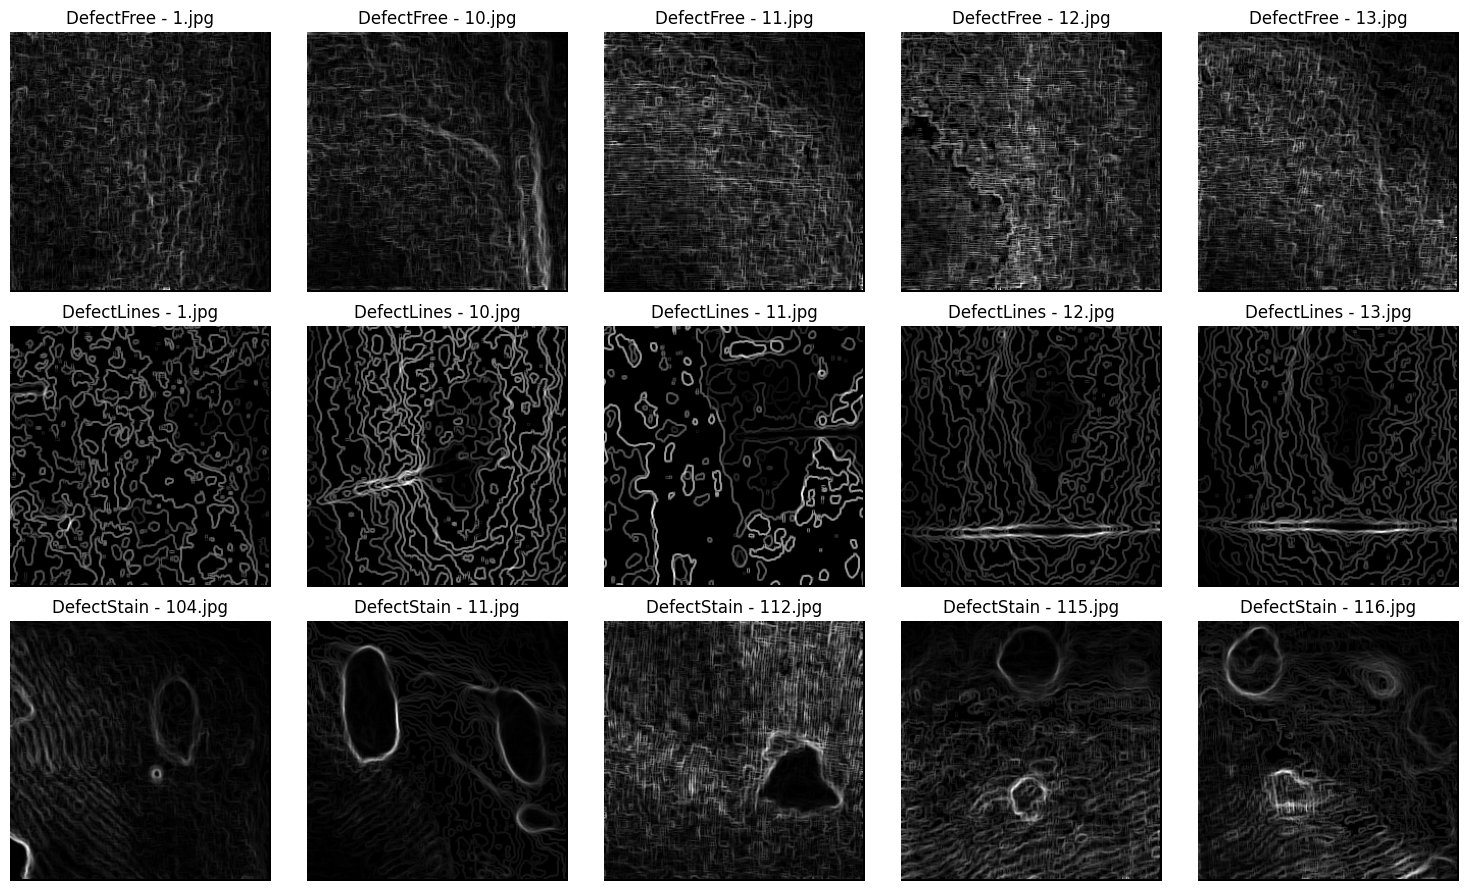

In [6]:
labels_unique = np.unique(labels)
fig, axs = plt.subplots(len(labels_unique), 5, figsize=(15, 3 * len(labels_unique)))

for i, label in enumerate(labels_unique):
    idx = np.where(labels == label)[0][:5]
    if len(idx) == 0:
        for j in range(5):
            axs[i, j].axis('off')
        continue
    for j in range(5):
        if j < len(idx):
            k = idx[j]
            axs[i, j].imshow(dataPreprocessed[k], cmap='gray')
            axs[i, j].set_title(f"{label} - {file_name[k]}")
            axs[i, j].axis('off')
        else:
            axs[i, j].axis('off')

plt.tight_layout()
plt.show()

Kode diatas berfungsi untuk menampilkan beberapa sampel citra hasil pra-pemrosesan dari masing-masing kelas label yang ada dalam dataset. Pertama, variabel labels_unique menyimpan daftar label unik dari seluruh citra yang telah dimuat. Kemudian, plt.subplots() digunakan untuk membuat grid plot dengan jumlah baris sebanyak jumlah label unik dan lima kolom untuk menampilkan maksimal lima contoh citra dari masing-masing kelas. Dalam perulangan, untuk setiap label, program mencari indeks citra yang termasuk ke dalam label tersebut menggunakan np.where(). Jika citra dengan label tertentu tidak ditemukan, maka seluruh kolom pada baris tersebut akan dinonaktifkan. Untuk setiap citra yang tersedia (maksimal lima per label), citra yang telah diproses (hasil dari dataPreprocessed) menggunakan imshow(), dengan judul yang menunjukkan nama label dan nama file aslinya. Sumbu gambar disembunyikan agar tampilan lebih bersih. Terakhir, plt.tight_layout() digunakan agar elemen-elemen plot tidak saling tumpang tindih, dan plt.show() menampilkan seluruh grid plot tersebut.

### Feature Extraction

In [7]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

Kode diatas adalah fungsi glcm() bertugas untuk menghitung matriks GLCM (Gray-Level Co-occurrence Matrix) dari sebuah citra grayscale dengan sudut tertentu. Matriks GLCM digunakan dalam pengolahan citra sebagai metode ekstraksi fitur tekstur dengan menghitung frekuensi kemunculan pasangan nilai piksel pada jarak dan arah tertentu. Fungsi ini menerima dua parameter: image, yaitu citra grayscale yang akan dihitung GLCM-nya, dan derajat, yaitu sudut kemunculan pasangan piksel (dalam derajat). Sudut tersebut diubah menjadi radian karena fungsi graycomatrix() dari pustaka skimage.feature menggunakan satuan radian. Sudut yang didukung adalah 0°, 45°, 90°, dan 135°, dan jika nilai sudut yang diberikan tidak sesuai, maka fungsi akan memunculkan error. GLCM dihitung dengan jarak antar piksel sebesar 1, dengan opsi symmetric=True untuk membuat matriks simetris, dan normed=True agar nilai dalam matriks dinormalisasi. Hasil keluaran dari fungsi ini adalah matriks GLCM berdimensi 4 yang siap digunakan untuk menghitung berbagai fitur tekstur seperti kontras, homogenitas, energi, dan korelasi.

In [8]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

Kode diatas adalah kumpulan fungsi ini digunakan untuk mengambil berbagai fitur tekstur dari matriks GLCM seperti korelasi, dissimilaritas, homogenitas, kontras, ASM, dan energi menggunakan fungsi graycoprops. Selain itu, ada fungsi untuk menghitung entropi GLCM yang mengukur kompleksitas tekstur. Fitur-fitur ini membantu menggambarkan pola dan struktur tekstur dalam citra untuk keperluan analisis dan klasifikasi.

In [9]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    img_uint8 = dataPreprocessed[i].astype(np.uint8)
    D0 = glcm(img_uint8, 0)
    D45 = glcm(img_uint8, 45)
    D90 = glcm(img_uint8, 90)
    D135 = glcm(img_uint8, 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

Kode diatas berfungsi untuk melakukan perhitungan matriks GLCM pada setiap citra hasil pra-pemrosesan (dataPreprocessed) untuk empat arah sudut berbeda: 0°, 45°, 90°, dan 135°. Setiap citra diubah ke tipe uint8 terlebih dahulu untuk memastikan sesuai dengan format input fungsi glcm(). Hasil GLCM untuk tiap sudut disimpan secara terpisah dalam list Derajat0, Derajat45, Derajat90, dan Derajat135. Pendekatan ini memungkinkan ekstraksi fitur tekstur yang mempertimbangkan variasi arah pada citra.

In [10]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

Kode diatas berfungsi untuk mendefinisikan beberapa list kosong yang akan digunakan untuk menyimpan nilai fitur tekstur yang diekstrak dari matriks GLCM pada empat sudut berbeda (0°, 45°, 90°, dan 135°). Setiap fitur seperti kontras, dissimilaritas, homogenitas, entropi, ASM, energi, dan korelasi memiliki empat list terpisah yang akan menampung hasil ekstraksi berdasarkan arah GLCM yang berbeda. Ini memudahkan pengorganisasian dan analisis fitur tekstur berdasarkan orientasi sudut masing-masing.

In [11]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [12]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [13]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [14]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [15]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [16]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [17]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

Kode diatas berfungsi untuk mengekstrak berbagai fitur tekstur dari matriks GLCM yang sudah dihitung untuk setiap citra dan untuk setiap sudut (0°, 45°, 90°, 135°). Dalam setiap loop, fungsi fitur seperti correlation(), contrast(), dissimilarity(), homogenity(), entropyGlcm(), ASM(), dan energy() dipanggil untuk matriks GLCM pada sudut tertentu, lalu hasilnya dimasukkan ke dalam list yang sesuai untuk masing-masing sudut. Dengan cara ini, setiap fitur tekstur akan memiliki nilai yang terpisah berdasarkan arah matriks GLCM, sehingga memberikan representasi lengkap tekstur citra dari berbagai orientasi.

### Write Hasil Extraction ke CSV

In [18]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1.jpg,DefectFree,241.209620,386.099669,196.739553,376.908235,0.131485,0.093376,0.149457,0.094516,...,0.001141,0.000678,0.032161,0.025897,0.033773,0.026048,0.667757,0.459036,0.724869,0.471921
1,10.jpg,DefectFree,179.536734,338.921922,215.666942,361.879431,0.149077,0.099072,0.143394,0.095692,...,0.000864,0.000576,0.030106,0.024215,0.029398,0.024002,0.793528,0.609727,0.752243,0.583245
2,11.jpg,DefectFree,334.919286,1003.183068,775.733931,1038.342053,0.133041,0.071173,0.098472,0.067537,...,0.000701,0.000404,0.028761,0.020638,0.026481,0.020105,0.793223,0.379781,0.522089,0.357978
3,12.jpg,DefectFree,450.155178,1397.152511,1094.073499,1412.071665,0.135059,0.066903,0.092680,0.064592,...,0.000995,0.000581,0.036759,0.024470,0.031548,0.024113,0.776593,0.305338,0.456803,0.297930
4,13.jpg,DefectFree,410.952727,879.166859,579.377160,868.962261,0.122424,0.076699,0.110636,0.075468,...,0.001007,0.000572,0.033051,0.024192,0.031730,0.023920,0.734270,0.430902,0.626851,0.437515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205,286.jpg,DefectStain,174.350827,761.099977,543.537653,535.999815,0.144154,0.077454,0.106130,0.088509,...,0.000584,0.000425,0.027189,0.019243,0.024172,0.020613,0.892177,0.527131,0.662803,0.666984
206,287.jpg,DefectStain,58.247074,83.553018,31.992616,80.490780,0.322124,0.256555,0.371839,0.265335,...,0.008265,0.005179,0.084440,0.071171,0.090910,0.071968,0.883720,0.833595,0.936137,0.839694
207,288.jpg,DefectStain,154.451562,228.833249,99.959743,222.973072,0.194569,0.148950,0.230951,0.148659,...,0.003516,0.002013,0.056395,0.044863,0.059296,0.044868,0.813915,0.723870,0.879243,0.730941
208,289.jpg,DefectStain,133.616605,218.814394,103.202803,197.020946,0.233117,0.171672,0.241858,0.179381,...,0.005859,0.003711,0.075180,0.060168,0.076546,0.060920,0.830819,0.723196,0.869226,0.750766


Kode diatas berfungsi untuk menggabungkan semua fitur tekstur yang sudah dihitung beserta nama file dan label citra ke dalam sebuah dictionary dataTable. Dictionary ini kemudian dikonversi menjadi sebuah DataFrame pandas yang berisi kolom-kolom fitur untuk tiap citra. Selanjutnya, DataFrame ini disimpan ke dalam file CSV bernama 'hasil_ekstraksi_1.csv' tanpa menyertakan indeks baris (index=False). Setelah itu, file CSV tersebut dibaca kembali ke dalam variabel hasilEkstrak sebagai DataFrame dan ditampilkan.

### Feature Selection menggunakan Correlation

<Axes: >

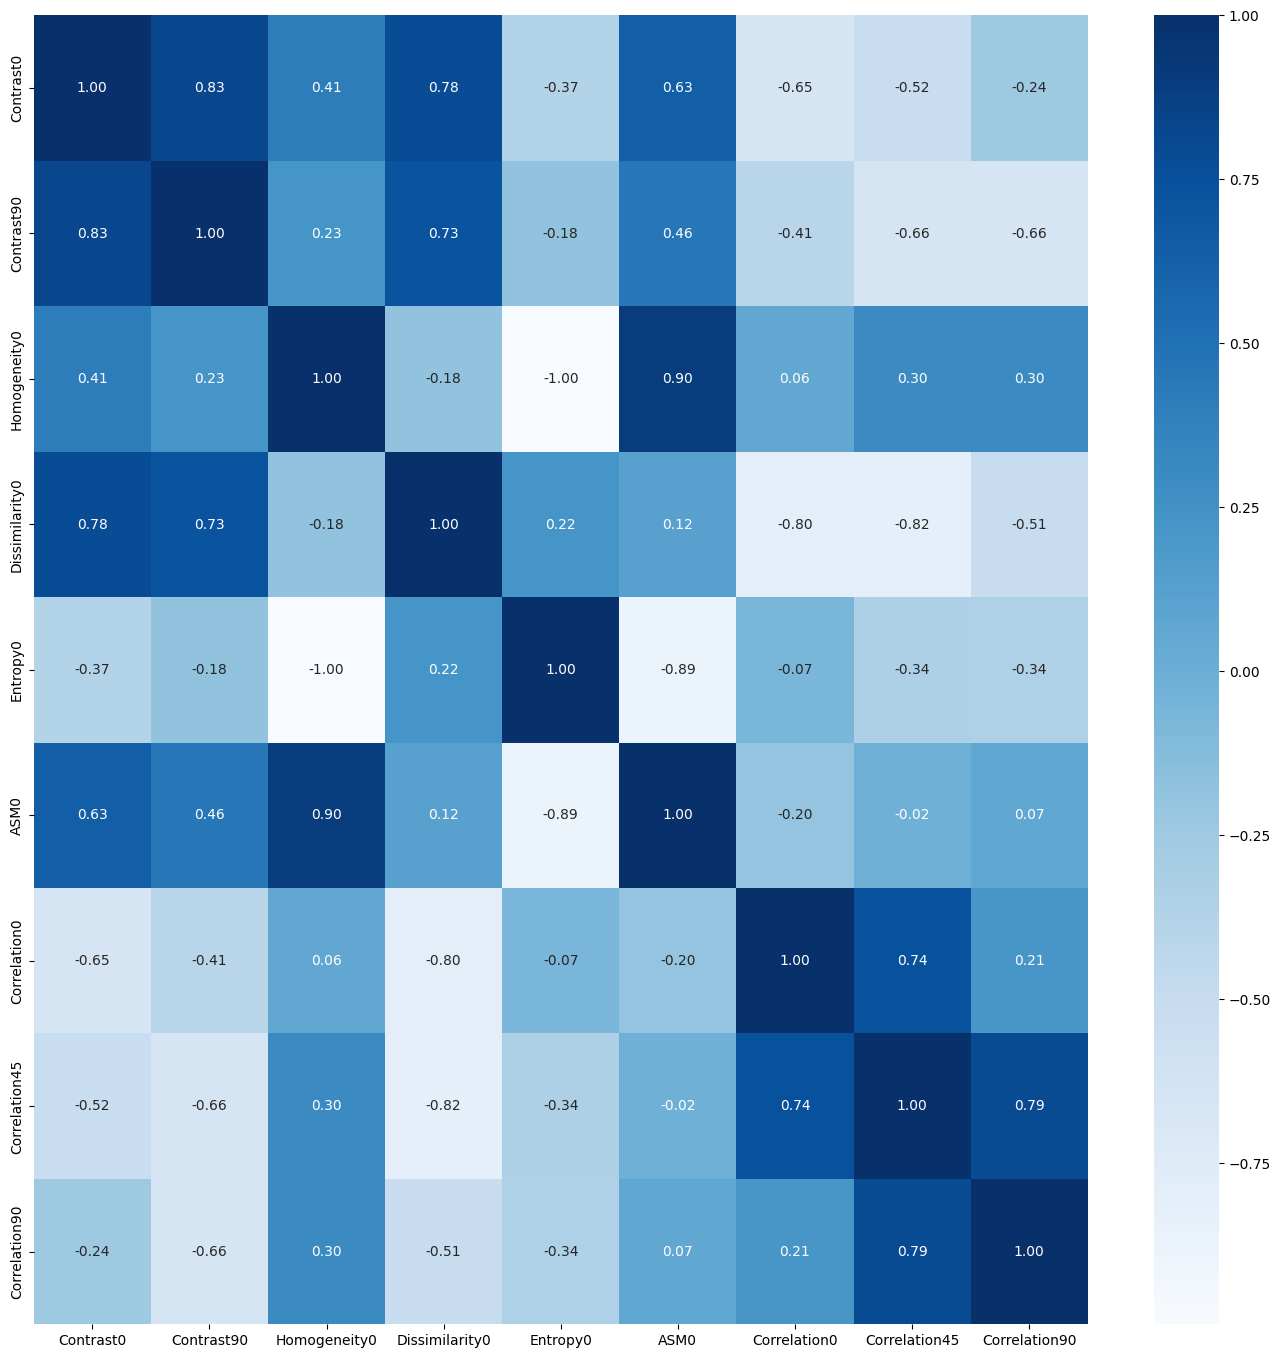

In [19]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

Kode diatas berfungsi untuk melakukan seleksi fitur berdasarkan korelasi data. Pertama, korelasi antar fitur (kecuali kolom Label dan Filename) dihitung menggunakan metode corr(). Kemudian, dengan menggunakan threshold korelasi absolut sebesar 0.95, fitur-fitur yang sangat berkorelasi satu sama lain akan disaring agar hanya satu dari fitur yang sangat mirip tersebut dipertahankan. Ini dilakukan dengan menandai fitur yang harus dihapus dalam array boolean columns. Hasil seleksi fitur disimpan dalam x_new, sedangkan label disimpan di y. Terakhir, kode ini menampilkan heatmap korelasi dari fitur terpilih menggunakan seaborn untuk visualisasi hubungan antar fitur yang sudah disaring.

## Splitting Data

In [20]:
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(168, 9)
(42, 9)


Kode diatas berfungsi untuk membagi dataset fitur (x_new) dan label (y) menjadi dua bagian: training data dan testing data dengan perbandingan 80% untuk pelatihan dan 20% untuk pengujian (test_size=0.2). Fungsi train_test_split dari sklearn.model_selection digunakan dengan random_state=42 agar pembagian data bersifat reproducible atau konsisten saat dijalankan ulang.

## Feature Normalization Menggunakan Standardization

In [21]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

Kode diatas berfungsi untuk melakukan normalisasi fitur pada data train (X_train) dan data testing (X_test) menggunakan metode standardisasi (z-score normalization). Setiap fitur pada kedua dataset diubah dengan cara mengurangi nilai rata-rata (mean) dari data latih dan membaginya dengan standar deviasi (std) data latih. Ini membuat fitur memiliki rata-rata nol dan standar deviasi satu berdasarkan statistik data latih, yang penting agar model belajar dengan lebih stabil dan hasilnya lebih konsisten saat diaplikasikan ke data uji. Normalisasi X_test menggunakan parameter mean dan std dari X_train untuk menjaga konsistensi transformasi

## Modelling

### Define Model

In [22]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

Kode diatas berfungsi untuk mendefinisikan fungsi generateClassificationReport yang berfungsi untuk mencetak tiga hal penting dalam evaluasi klasifikasi: laporan klasifikasi (classification_report) yang memuat precision, recall, dan f1-score; matriks kebingungan (confusion_matrix) yang menunjukkan performa klasifikasi per kelas; serta nilai akurasi (accuracy_score) sebagai metrik keseluruhan.

### Train Random Forest Classifier

In [23]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

  DefectFree       1.00      0.97      0.98        59
 DefectLines       1.00      0.98      0.99        56
 DefectStain       0.95      1.00      0.97        53

    accuracy                           0.98       168
   macro avg       0.98      0.98      0.98       168
weighted avg       0.98      0.98      0.98       168

[[57  0  2]
 [ 0 55  1]
 [ 0  0 53]]
Accuracy: 0.9821428571428571

------Testing Set------
              precision    recall  f1-score   support

  DefectFree       0.64      0.82      0.72        11
 DefectLines       1.00      0.93      0.96        14
 DefectStain       0.87      0.76      0.81        17

    accuracy                           0.83        42
   macro avg       0.84      0.84      0.83        42
weighted avg       0.85      0.83      0.84        42

[[ 9  0  2]
 [ 1 13  0]
 [ 4  0 13]]
Accuracy: 0.8333333333333334


Kode diatas berfungsi untuk melatih model Random Forest dengan data latih (X_train, y_train). Setelah pelatihan selesai, model digunakan untuk memprediksi label pada data latih dan kemudian hasilnya dievaluasi dengan laporan klasifikasi dan confusion matrix untuk menilai performa pada data latih. Selanjutnya, model juga diuji pada data uji (X_test) dan hasil prediksinya dievaluasi dengan cara yang sama, sehingga kita dapat membandingkan performa model Random Forest pada data pelatihan dan data pengujian.

### Train SVM Classifier

In [24]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

  DefectFree       0.95      0.97      0.96        59
 DefectLines       1.00      0.84      0.91        56
 DefectStain       0.84      0.96      0.89        53

    accuracy                           0.92       168
   macro avg       0.93      0.92      0.92       168
weighted avg       0.93      0.92      0.92       168

[[57  0  2]
 [ 1 47  8]
 [ 2  0 51]]
Accuracy: 0.9226190476190477

------Testing Set------
              precision    recall  f1-score   support

  DefectFree       0.62      0.91      0.74        11
 DefectLines       1.00      0.79      0.88        14
 DefectStain       0.87      0.76      0.81        17

    accuracy                           0.81        42
   macro avg       0.83      0.82      0.81        42
weighted avg       0.85      0.81      0.82        42

[[10  0  1]
 [ 2 11  1]
 [ 4  0 13]]
Accuracy: 0.8095238095238095


Kode diatas berfungsi untuk melatih model SVM (Support Vector Machine) dengan data latih (X_train, y_train). Setelah pelatihan selesai, model digunakan untuk memprediksi label pada data latih dan kemudian hasilnya dievaluasi dengan laporan klasifikasi dan confusion matrix untuk menilai performa pada data latih. Selanjutnya, model juga diuji pada data uji (X_test) dan hasil prediksinya dievaluasi dengan cara yang sama, sehingga kita dapat membandingkan performa model SVM pada data pelatihan dan data pengujian.

### Train KNN Classifier

In [25]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

  DefectFree       0.95      0.97      0.96        59
 DefectLines       1.00      0.91      0.95        56
 DefectStain       0.91      0.98      0.95        53

    accuracy                           0.95       168
   macro avg       0.95      0.95      0.95       168
weighted avg       0.95      0.95      0.95       168

[[57  0  2]
 [ 2 51  3]
 [ 1  0 52]]
Accuracy: 0.9523809523809523

------Testing Set------
              precision    recall  f1-score   support

  DefectFree       0.59      0.91      0.71        11
 DefectLines       1.00      0.79      0.88        14
 DefectStain       0.93      0.76      0.84        17

    accuracy                           0.81        42
   macro avg       0.84      0.82      0.81        42
weighted avg       0.86      0.81      0.82        42

[[10  0  1]
 [ 3 11  0]
 [ 4  0 13]]
Accuracy: 0.8095238095238095


Kode diatas berfungsi untuk melatih model KNN (K-Nearest Neighbors) dengan data latih (X_train, y_train). Setelah pelatihan selesai, model digunakan untuk memprediksi label pada data latih dan kemudian hasilnya dievaluasi dengan laporan klasifikasi dan confusion matrix untuk menilai performa pada data latih. Selanjutnya, model juga diuji pada data uji (X_test) dan hasil prediksinya dievaluasi dengan cara yang sama, sehingga kita dapat membandingkan performa model KNN pada data pelatihan dan data pengujian.

## Evaluation With Confusion Matrix

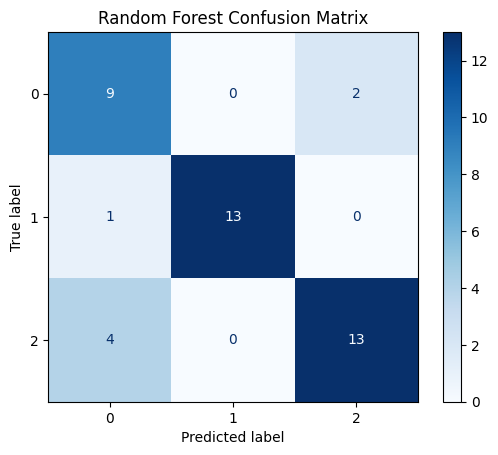

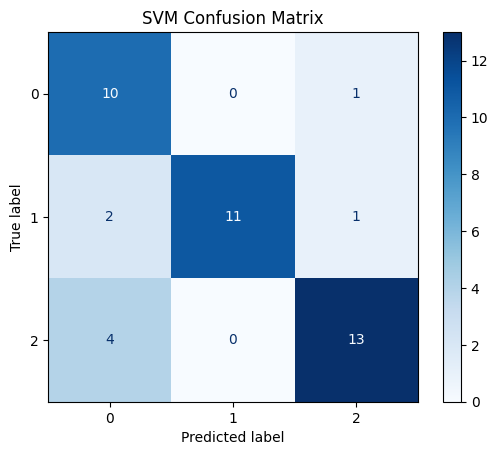

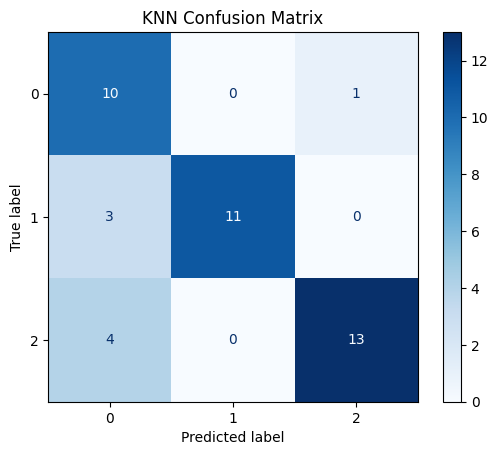

In [26]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")

Kode diatas berfungsi untuk membuat fungsi plot_confusion_matrix untuk menampilkan confusion matrix dengan visualisasi warna biru menggunakan ConfusionMatrixDisplay dari sklearn. Fungsi ini menerima label asli (y_true), prediksi model (y_pred), dan judul grafik (title). Kemudian, fungsi ini dipanggil untuk menampilkan matriks kebingungan dari hasil prediksi pada data uji (X_test) untuk tiga model yang telah dilatih: Random Forest, SVM, dan KNN.